### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV,StratifiedKFold,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from collections import defaultdict

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [160]:
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini',feature_importances = None):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.num_class = 0
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.criterion = criterion
        # Для последнего задания
        self.feature_importances_ = feature_importances
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        
        if(self.criterion == 'gini'):
            self.g_func = self.__F_g
        elif(self.criterion == 'entro'):
            self.g_func = self.__F_h
        elif(self.criterion == 'comp'):
            self.g_func = self.__F_e
        if(self.feature_importances_ is not None):
            self._fitch_dict = defaultdict(int)
    
    def __find_trash(self,x,y,indec):
        ind = x[:,indec].argsort()
        y_sort = y[ind]
        x_sort = x[:,indec][ind]
        num_class = self.num_class
        swap_ind = np.where(y_sort[:-1]!=y_sort[1:])[0] +1#находим все разделители
        if(swap_ind.size == 0):#если все объекты одного класса ничего не разделяем, 
            return -np.inf,None
        swap_size = swap_ind.size
        ZerOne = np.zeros((swap_size,num_class))#матрица, в которой за 1 отвечает класс разделитель
        ZerOne[np.arange(swap_size),y_sort[swap_ind-1]] = 1
        new_swap = np.copy(swap_ind)
        swap_ind[1:] = swap_ind[1:] - swap_ind[:-1]
        counts = swap_ind.reshape(-1,1)
        New_MAtrix = ZerOne * (counts)#количесвто объектов между разделениями одного класса
        label =  np.bincount(y_sort, minlength=num_class)#количество классов вообще
        l_l = np.cumsum(New_MAtrix,axis = 0)#колличества классов слева после разбиения
        l_r = label - l_l #справа
        shape_l = new_swap.reshape(l_l.shape[0], 1)#общее количество объектов слева
        shape_r = y.size - shape_l #справа
        g_func = self.g_func(l_l,shape_l,l_r,shape_r)
       # print(g_func.shape)
        ind = (g_func).argmax()
        return g_func[ind],(x_sort[new_swap[ind]] + x_sort[new_swap[ind]])/2


    def __F_g(self,l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float').reshape(-1,1)
        r_s = r_s.astype('float').reshape(-1,1)
        F_1 = (1 - np.sum(((l_c+r_c)/(l_s+r_s))**2,axis = 1)).reshape(-1,1)
        F_l = (1 - np.sum(((l_c)/(l_s))**2,axis = 1)).reshape(-1,1)*l_s/(l_s+r_s)
        F_r = (1 - np.sum(((r_c)/(r_s))**2,axis = 1)).reshape(-1,1)*r_s/(l_s+r_s)
        return F_1 - F_l - F_r
    def __F_h(self,l_c, l_s, r_c, r_s):
        a = np.random.rand()/1000
        l_s = l_s.astype('float') + a
        r_s = r_s.astype('float') + a
        F_1 = (-np.sum((l_c+r_c+a)/(l_s+r_s)*np.log((l_c+r_c+a)/(l_s+r_s)),axis = 1)).reshape(-1,1)
        F_l = (-np.sum((l_c+a)/l_s*np.log((l_c+a)/l_s),axis = 1)).reshape(-1,1)*l_s/(l_s+r_s)
        F_r = (-np.sum(((r_c+a)/r_s)*np.log((r_c+a)/r_s),axis = 1)).reshape(-1,1)*r_s/(l_s+r_s)
        return F_1 - F_l - F_r
    def __F_e(self,l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        F_1 = (1 - np.max((l_c+r_c)/(l_s+r_s),axis = 1)).reshape(-1,1)
        F_l = (1 - np.max((l_c)/(l_s),axis = 1)).reshape(-1,1)*l_s/(l_s+r_s)
        F_r = (1 - np.max((r_c)/(r_s),axis = 1)).reshape(-1,1)*r_s/(l_s+r_s)
        return F_1 - F_l - F_r
    
    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        indec = np.arange(x.shape[1])
        return  max([(self.__find_trash(x,y,i),i) for i in indec])

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if(self.max_depth is not None and self.max_depth<=depth) or\
           (y.size <= self.min_samples_split) or (np.bincount(y).shape[0] == 1):
            a,b = np.unique(y,return_counts = True)
            MAX_B = b.argmax()
            c = a[MAX_B]
            p = b[MAX_B]/y.size
            self.tree[node_id] = (self.LEAF_TYPE,c,p)
        else:
            kof1,best_id = self.__find_threshold(x, y)
            best_tr = kof1[1]
            if best_tr is None:
                self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / y.size)
            else:
                x_l, x_r, y_l, y_r =self.__div_samples(x, y, best_id, best_tr)
                if(self.feature_importances_ is not None):
                    self._fitch_dict[best_id] += kof1[0]
                if(y_l.size == 0 or y_r.size == 0):
                    a,b = np.unique(y,return_counts = True)
                    MAX_B = b.argmax()
                    c = a[MAX_B]
                    p = b[MAX_B]/y.size
                    self.tree[node_id] = (self.LEAF_TYPE,c,p)
                else:
                    self.tree[node_id] = (self.NON_LEAF_TYPE,best_id, best_tr)
                    self.__fit_node(x_l, y_l,2 * node_id + 1, depth + 1)
                    self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
        
        
        
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self,N):
        """
        Возвращает важность признаков
        """
        item = sorted(self._fitch_dict.items(),
                      key = lambda par: par[1],reverse = True)[:N]
        return item
    

In [161]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [162]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [163]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [164]:
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8888888888888888
0.8888888888888888


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [165]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [166]:
%time clf.fit(X_train, y_train)

Wall time: 2 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [167]:
%time my_clf.fit(X_train, y_train)

Wall time: 18 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [169]:

df = pd.read_csv('C:/Users/willi/OneDrive/Рабочий стол/техносфера/1 семак/Алгоритмы интелектуальной обработки больших данных/'
                       '3 дз/Speed Dating Data.csv', encoding='latin1')


df = df.iloc[:, :97]
df = df.drop(['id', 'idg', 'condtn', 'round', 'position',
              'positin1', 'order', 'partner', 'age_o', 'race_o',
              'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun',
              'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o',
              'sinc_o', 'intel_o', 'fun_o', 'amb_o',
              'shar_o', 'like_o', 'prob_o', 'met_o', 'field',
              'undergra', 'from', 'zipcode', 'career',
              'sports', 'tvsports', 'exercise', 'dining',
              'museums', 'art', 'hiking', 'gaming',
              'clubbing', 'reading', 'tv', 'theater',
              'movies', 'concerts', 'music', 'shopping', 'yoga',
              'expnum', ], axis=1)


df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.tuition.fillna(-999)
df = df.dropna(subset=['imprelig', 'imprace'])
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)


feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100


feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)


for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)
    
df = df.drop(['wave'], axis=1)

df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid']).drop(['gender'], axis=1).dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid']).drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
df_female.columns = df_female.columns + '_f'
df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)

feature_names = df_pair.columns[1:]

In [174]:
df_pair.shape

(3999, 63)

In [170]:
y = df_pair.loc[:, 'match'].values
X = df_pair.drop('match', axis=1).iloc[:,0:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

my_clf = MyDecisionTreeClassifier()
clf = DecisionTreeClassifier(min_samples_split=2,max_depth=5,criterion='gini')

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)


print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.81
0.8225


In [171]:
%time clf.fit(X_train, y_train)

Wall time: 32 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [172]:
%time my_clf.fit(X_train, y_train)

Wall time: 206 ms


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [124]:
def best_criterion(X,y,cv):
    names_criterion = ['gini','entro','comp']
    means = []
    for name in names_criterion:
        model = MyDecisionTreeClassifier(min_samples_split=2,
                                         criterion = name)

        means.append(cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean())
    return means

def best_deep(X,y,cv,depths,criterion,mod = 'my'):
    means = []
    for depth in depths:
        if(mod == 'my'):
            model = MyDecisionTreeClassifier(min_samples_split = 2,
                                             max_depth = depth,
                                             criterion = criterion)
        else:
            model = DecisionTreeClassifier(min_samples_split=2,
                                           max_depth = depth)
            
            
        means.append(cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean())
    return means

def best_min_samples(X,y,cv,criterion,max_depth,samples):
    means = []
    for sample in samples:
        model = MyDecisionTreeClassifier(min_samples_split=sample,
                                         max_depth = max_depth,
                                        criterion = criterion)
        means.append(cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean())
    return means

    
    

In [125]:
means_criterions = best_criterion(X_train,y_train,cv = 8)

In [126]:
means_criterions

[0.8338424894828013, 0.8374560752289038, 0.8335647117050236]

In [127]:
best_criterion = ['gini','entro','comp'][np.argmax(means_criterions)]

In [128]:
dict(zip(['gini','entro','comp'],means_criterions))

{'gini': 0.8338424894828013,
 'entro': 0.8374560752289038,
 'comp': 0.8335647117050236}

In [129]:
depths = np.arange(10,100)
means_deep = best_deep(X = X_train,
                       y = y_train,
                       cv = 8,
                       depths = depths,
                      criterion = 'entro')

In [130]:
best_depth = depths[np.argmax(means_deep)]

In [131]:
samples = np.arange(1,100)
means_samples = best_min_samples(X = X_train,
                                 y = y_train,
                                 cv = 8,
                                 samples = samples,
                                 criterion = 'entro',
                                 max_depth = best_depth)

In [132]:
best_sample =  samples[np.argmax(means_samples)]

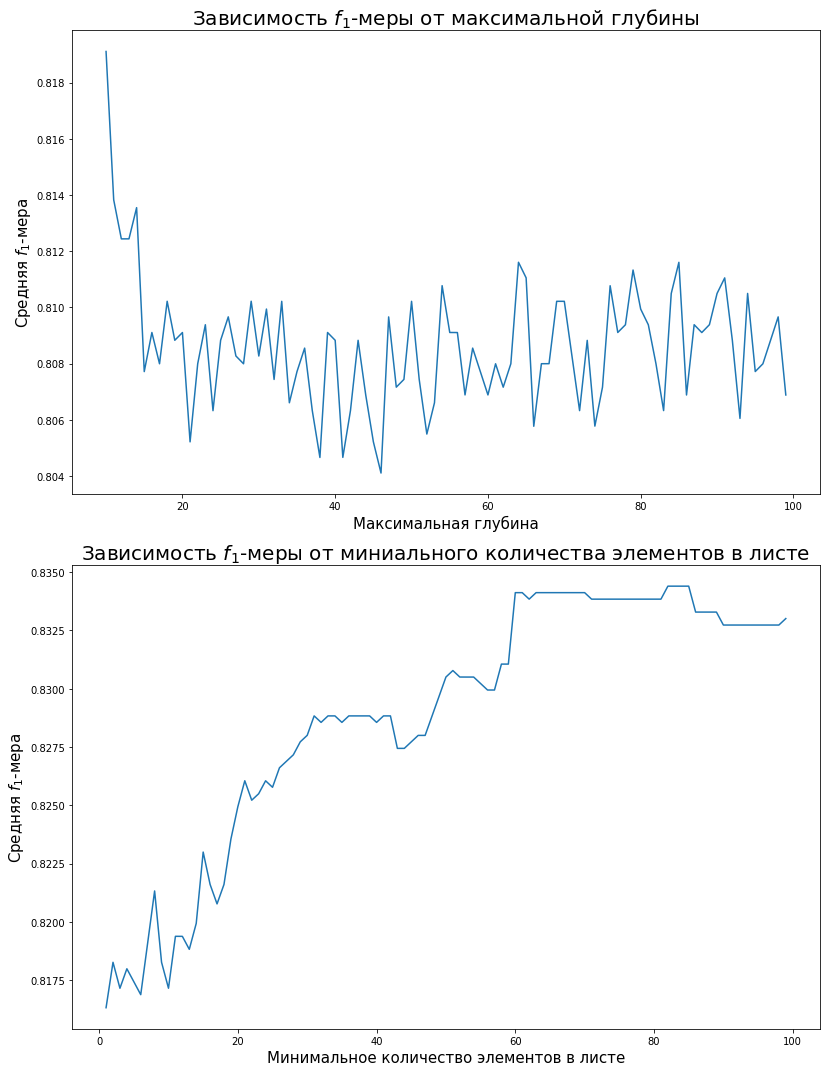

In [133]:
fig,axes = plt.subplots(2,1,figsize = (12,15))

axes[0].plot(depths,means_deep)
axes[1].plot(samples,means_samples)

axes[0].set_ylabel(u'Средняя $f_1$-мера',fontsize = 15)
axes[1].set_ylabel(u'Средняя $f_1$-мера',fontsize = 15)

axes[0].set_xlabel(u'Максимальная глубина',fontsize = 15)
axes[1].set_xlabel(u'Минимальное количество элементов в листе',fontsize = 15)

axes[0].set_title(u'Зависимость $f_1$-меры от максимальной глубины',fontsize = 20)
axes[1].set_title(u'Зависимость $f_1$-меры от миниального количества элементов в листе',fontsize = 20)

fig.tight_layout()

На данных графиках видно, что, в случае принятия в качестве функционала качества функционала, построенного на энтропии, дерево начинает сильно переобучаться при увеличении максимальной глубины и уменьшении минимального количества элементов в листе.

In [134]:
means_samples[np.argmax(means_samples)]#Лучший результат

0.8343955704033656

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [135]:
my_clf = MyDecisionTreeClassifier(criterion = best_criterion,
                                  max_depth = best_depth,
                                  min_samples_split = best_sample,
                                  feature_importances = True)
my_clf.fit(X_train, y_train)

In [136]:
first = my_clf.get_feature_importance(10)

In [137]:
featchs = []
for i,column in enumerate(df.columns):
    featchs.append((i,column))

In [138]:
def features_name(first_feature,sec_feature):
    names = []
    for indc in first_feature:
        for nm in sec_feature:
            if(indc[0] == nm[0]):
                names.append(nm[1])
    return names

In [139]:
features_name(first,featchs)#самые значимые критерии

['tuition', 'intel3_1', 'imprelig', 'fun2_1', 'intel2_1', 'imprace']

На валидации были получены структурные параметры, которые позволяют обучить дерево за меньшее количество сплитов, чем 10, за счет чего всего было получено меньше 10 наиболее значимых критериев.

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Решающие деревья являются интересными математическими алгоритмами  принятия решений. С их помощью можно выделять важные признаки, а также получать хорошее качество предсказаний на табличных данных. Интересно еще то, что решающие деревья обучаются очень быстро, несмотря на то, что при их обучении не используются градиентные методы подбора параметров. 